In [1]:
# Edited by: Kok Teng Ng (1936360), Minjeong Lee (1978925)
# IE 678 Deep Learning, University of Mannheim
# Author: Rainer Gemulla

In [1]:
%matplotlib ipympl

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# import helper functions
import sys, os

sys.path.append(os.getcwd())
from a01helper import *  # check out the helper functions there, if you like

# Task 1: Implement an MLP

## 1a Logistic Regression

In [3]:
# nn.Module is the superclass of all PyTorch models.
class LogisticRegression(nn.Module):
    """A logistic regression model.

    Parameters
    ----------
    D number of inputs
    C number of classes
    """

    # the definition of all parameters the model uses happens here, i.e., during
    # initialization
    def __init__(self, D, C):
        super(LogisticRegression, self).__init__()

        # Create and initialize model parameters. For (multinomial) logistic regression,
        # we have a DxC-dimensional weight matrix W and a C-dimensional bias b.
        self.W = torch.randn(D, C) / math.sqrt(D)
        self.b = torch.randn(C) / math.sqrt(C)

        # Model parameters must be registered to PyTorch as follows. Here we provide
        # a useful name that helps to access/analyze the model later on.
        self.register_parameter("0_weight", nn.Parameter(self.W))
        self.register_parameter("0_bias", nn.Parameter(self.b))

    # the forward function computes the model output for the provided (for this
    # assignent: single) input
    def forward(self, x):
        eta = self.W.t() @ x + self.b
        logprob = F.log_softmax(eta, dim=-1)
        return logprob

In [4]:
# let's test it
logreg = LogisticRegression(3, 2)
x = torch.rand(3)  # input
logreg(x)  # output (log probabilities)
logreg(x).exp()  # output (probabilities)

tensor([0.7939, 0.2061])

In [5]:
# you can access individual parameters as follows
logreg.get_parameter("0_bias")

Parameter containing:
tensor([-0.0527, -0.8002], requires_grad=True)

In [6]:
# or all of them at once
list(logreg.named_parameters())

[('0_weight',
  Parameter containing:
  tensor([[ 0.2860, -0.3515],
          [ 0.7918, -0.1698],
          [ 0.0949, -0.5201]], requires_grad=True)),
 ('0_bias',
  Parameter containing:
  tensor([-0.0527, -0.8002], requires_grad=True))]

In [7]:
# or directly the tensors stored in the parameters
for par, value in logreg.state_dict().items():
    print(f"{par:<15}= {value}")

0_weight       = tensor([[ 0.2860, -0.3515],
        [ 0.7918, -0.1698],
        [ 0.0949, -0.5201]])
0_bias         = tensor([-0.0527, -0.8002])


## 1b MLP

In [8]:
class MLP(nn.Module):
    """A fully-connected MLP.

    Parameters
    ----------

    sizes Contains the layer sizes. The first entry is the number of inputs, the last
    entry the number of outputs. All entries in between correspond to the number of
    units in the respective hidden layer. E.g., [2,5,7,1] means: 2 inputs -> 5D hidden
    layer -> 7D hidden layer -> 1 output.

    phi Activation function used in every hidden layer (the output layer is linear).

    """
    def __init__(self, sizes: list[int], phi=F.sigmoid):
        super().__init__()

        # let's remember the specification in this model
        self.sizes = sizes
        self.phi = phi

        # Initialize and register the parameters. Follow the naming scheme used for
        # logistic regression above, i.e., the layer-i weights should be named "i_weight" and
        # "i_bias".
        
        for i in range(1, len(sizes)):
            self.register_parameter(f'{i - 1}_weight', torch.nn.Parameter(torch.randn(sizes[i - 1], sizes[i]) / math.sqrt(sizes[i - 1])))
            self.register_parameter(f'{i - 1}_bias', torch.nn.Parameter(torch.randn(sizes[i]) / math.sqrt(sizes[i])))

    def num_layers(self):
        """Number of layers (excluding input layer)"""
        return len(self.sizes) - 1

    def forward(self, x):
        for i in range(0, self.num_layers() - 1):
            weight = getattr(self, f"{i}_weight")
            bias = getattr(self, f"{i}_bias")
            x = weight.t() @ x + bias
            x = self.phi(x)
        weight = getattr(self, f"{self.num_layers() - 1}_weight")
        bias = getattr(self, f"{self.num_layers() - 1}_bias")
        x = weight.t() @ x + bias
        return x

In [9]:
# here you should see the correct parameter sizes
mlp = MLP([2, 3, 4, 2], torch.relu)
list(mlp.named_parameters())

[('0_weight',
  Parameter containing:
  tensor([[ 1.3332, -0.7889, -0.1944],
          [-1.3557, -0.8821,  0.5116]], requires_grad=True)),
 ('0_bias',
  Parameter containing:
  tensor([-0.0612,  0.0403,  0.2524], requires_grad=True)),
 ('1_weight',
  Parameter containing:
  tensor([[ 0.0520,  0.9118, -0.8067,  0.4872],
          [-0.0393, -0.1332, -0.2776, -1.2511],
          [-0.8496, -1.6695, -0.0441, -0.6048]], requires_grad=True)),
 ('1_bias',
  Parameter containing:
  tensor([ 0.2837,  0.1361, -0.0046, -0.0430], requires_grad=True)),
 ('2_weight',
  Parameter containing:
  tensor([[-0.4725,  0.1120],
          [-0.6550, -0.0543],
          [ 0.1234,  0.2692],
          [ 0.1050,  0.6524]], requires_grad=True)),
 ('2_bias',
  Parameter containing:
  tensor([-0.7397, -0.8265], requires_grad=True))]

In [10]:
# Test your code; we fix the parameters and check the result
with torch.no_grad():
    torch.manual_seed(0)
    for l in range(mlp.num_layers()):
        W, b = mlp.get_parameter(f"{l}_weight"), mlp.get_parameter(f"{l}_bias")
        W[:] = torch.randn(W.shape)
        b[:] = torch.randn(b.shape)

mlp(torch.tensor([-1.0, 2.0]))  # must give: [ 0.8315, -3.6792]

tensor([ 0.8315, -3.6792], grad_fn=<AddBackward0>)

In [11]:
# You can also evaluate your model on multiple inputs at once. Here "torch.func.vmap"
# produces a function that applies the provided function (mlp#forward) to each row of
# its argument (torch.tensor...).
#
# [[ 0.8315, -3.6792],
# [ 4.8448, -6.8813]]
torch.func.vmap(mlp)(torch.tensor([[-1.0, 2.0], [1.0, -2.0]]))

tensor([[ 0.8315, -3.6792],
        [ 4.8448, -6.8813]], grad_fn=<AddBackward0>)

## 1c Batching

In [12]:
class MLP(nn.Module):
    def __init__(self, sizes: list[int], phi=F.sigmoid):
        super().__init__()

        self.sizes = sizes
        self.phi = phi
        
        for i in range(1, len(sizes)):
            self.register_parameter(f'{i - 1}_weight', torch.nn.Parameter(torch.randn(sizes[i - 1], sizes[i]) / math.sqrt(sizes[i - 1])))
            self.register_parameter(f'{i - 1}_bias', torch.nn.Parameter(torch.randn(sizes[i]) / math.sqrt(sizes[i])))

    def num_layers(self):
        return len(self.sizes) - 1

    def forward(self, x):
        if x.dim == 1:
            x = x.unsqueeze(0)
        for i in range(0, self.num_layers() - 1):
            weight = getattr(self, f"{i}_weight")
            bias = getattr(self, f"{i}_bias")
            x = x @ weight + bias.unsqueeze(0)
            x = self.phi(x)
        weight = getattr(self, f"{self.num_layers() - 1}_weight")
        bias = getattr(self, f"{self.num_layers() - 1}_bias")
        x = x @ weight + bias.unsqueeze(0)
        return x

In [13]:
# here you should see the correct parameter sizes
mlp = MLP([2, 3, 4, 2], torch.relu)

In [14]:
# Test your code; we fix the parameters and check the result
with torch.no_grad():
    torch.manual_seed(0)
    for l in range(mlp.num_layers()):
        W, b = mlp.get_parameter(f"{l}_weight"), mlp.get_parameter(f"{l}_bias")
        W[:] = torch.randn(W.shape)
        b[:] = torch.randn(b.shape)

In [15]:
# After you adapted the MLP class, you should get the same results as above.
mlp(torch.tensor([-1.0, 2.0]))  # must give: [ 0.8315, -3.6792]

tensor([[ 0.8315, -3.6792]], grad_fn=<AddBackward0>)

In [16]:
# Now without vmap. Only proceed to task 2 once this works correctly.
#
# [[ 0.8315, -3.6792],
# [ 4.8448, -6.8813]]
mlp(torch.tensor([[-1.0, 2.0], [1.0, -2.0]]))

tensor([[ 0.8315, -3.6792],
        [ 4.8448, -6.8813]], grad_fn=<AddBackward0>)

# 2 Multi-Layer Feed-Forward Neural Networks

## 2a Conjecture how an FNN fit will look like

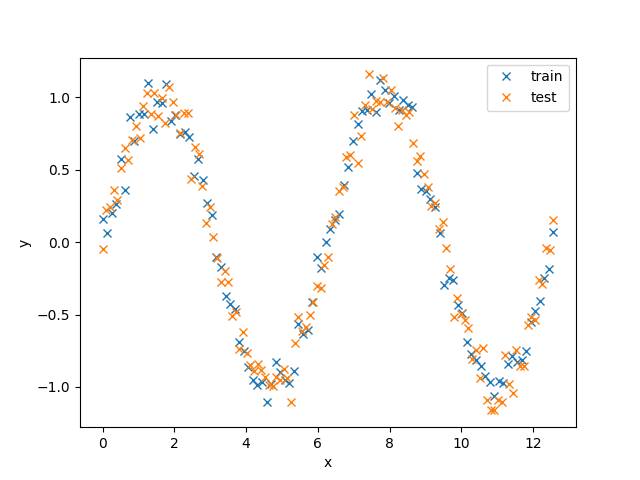

In [17]:
# here is the one-dimensional dataset that we will use
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plt.legend()

## 2b Train with 2 hidden units

In [18]:
# Training code. You do not need to modify this code.
train_bfgs = lambda model, **kwargs: train_scipy(X1, y1, model, **kwargs)

def train1(hidden_sizes, nreps=10, phi=F.sigmoid, train=train_bfgs, **kwargs):
    
    """Train an FNN.

    hidden_sizes is a (possibly empty) list containing the sizes of the hidden layer(s).
    nreps refers to the number of repetitions.

    """
    
    best_model = None
    best_cost = math.inf
    for rep in range(nreps):
        model = MLP([1] + hidden_sizes + [1], phi)  # that's your model!
        print(f"X1 shape: {X1.shape}")
        print(f"Repetition {rep: 2d}: ", end="")
        model = train(model, **kwargs)
        mse = F.mse_loss(y1, model(X1)).item()
        if mse < best_cost:
            best_model = model
            best_cost = mse
        print(f"best_cost={best_cost:.3f}")

    return best_model

In [19]:
# Let's fit the model with one hidden layer consisting of 2 units.
model = train1([2], nreps=1)
print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

X1 shape: torch.Size([100, 1])
Repetition  0: Optimization terminated successfully.
         Current function value: 0.293673
         Iterations: 120
         Function evaluations: 240
         Gradient evaluations: 233
best_cost=0.294
Training error: 0.29367321729660034
Test error    : 0.30551230907440186


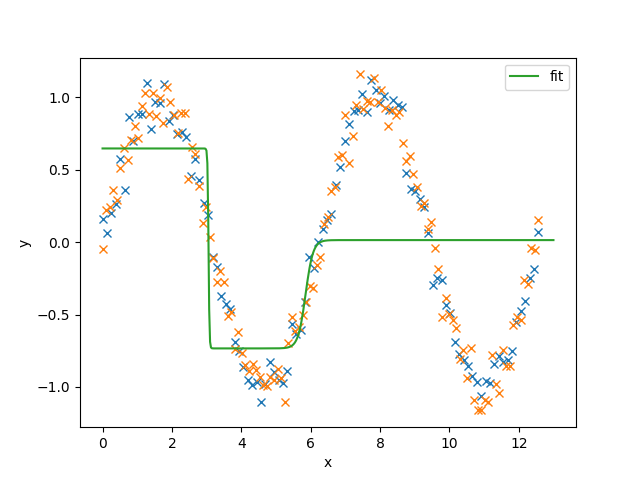

In [20]:
# plot the data and the fit
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

In [21]:
# The weight matrices and bias vectors can be read out as follows. If you want, use
# these parameters to compute the output of the network (on X1) directly and compare to
# vmap(model)(X1).
for par, value in model.state_dict().items():
    print(f"{par:<15}= {value}")

0_weight       = tensor([[75.7091,  9.2566]])
0_bias         = tensor([-231.3285,  -54.1847])
1_weight       = tensor([[-1.3810],
        [ 0.7480]])
1_bias         = tensor([0.6471])


X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.079572
         Iterations: 387
         Function evaluations: 521
         Gradient evaluations: 511
best_cost=0.080
Training error: 0.07957355678081512
Test error    : 0.08671201020479202


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


X1 shape: torch.Size([100, 1])
Repetition  0: Optimization terminated successfully.
         Current function value: 0.303902
         Iterations: 143
         Function evaluations: 155
         Gradient evaluations: 155
best_cost=0.304
Training error: 0.30390220880508423
Test error    : 0.3037970960140228
X1 shape: torch.Size([100, 1])
Repetition  0: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 400
         Function evaluations: 562
         Gradient evaluations: 551
best_cost=0.080
Training error: 0.07957581430673599
Test error    : 0.0867120772600174
X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.286909
         Iterations: 302
         Function evaluations: 458
         Gradient evaluations: 445
best_cost=0.287
Training error: 0.28690817952156067
Test error    : 0.29484879970550537
X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.079573
         Iterations: 336
         Function evaluations: 470
         Gradient evaluations: 458
best_cost=0.080
Training error: 0.07956987619400024
Test error    : 0.0867103710770607


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


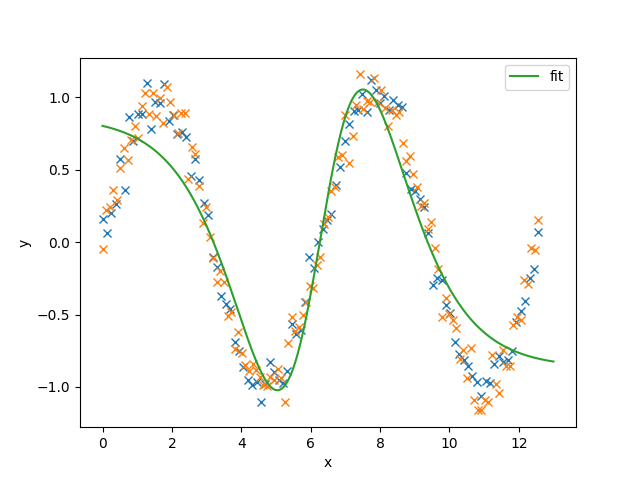

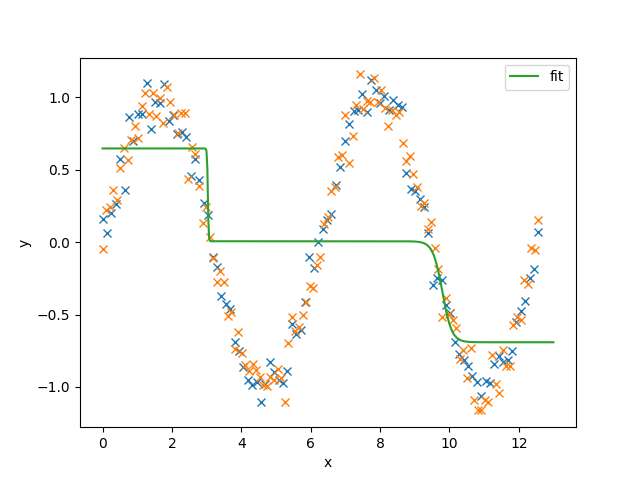

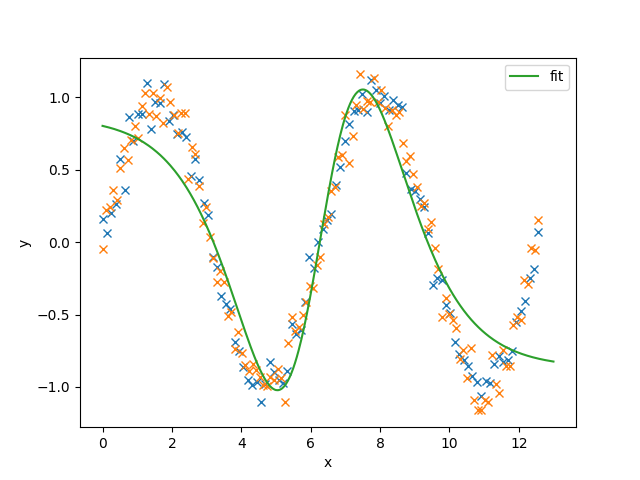

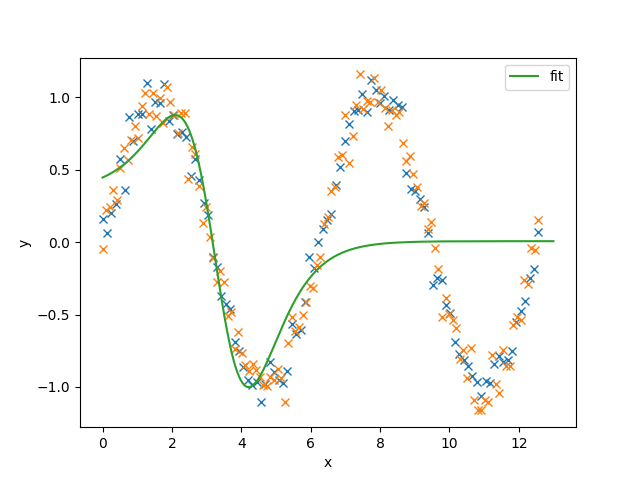

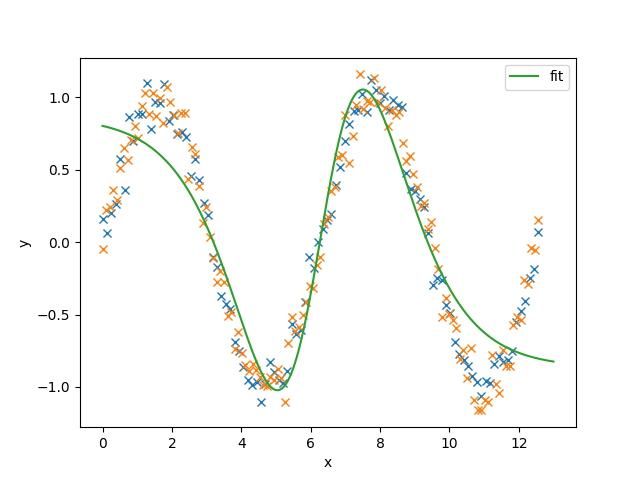

In [22]:
# now repeat this multiple times
for i in range (0, 5):
    model = train1([2], nreps=1)
    print("Training error:", F.mse_loss(y1, model(X1)).item())
    print("Test error    :", F.mse_loss(y1test, model(X1test)).item())
    nextplot()
    plot1(X1, y1, label="train")
    plot1(X1test, y1test, label="test")
    plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

In [23]:
# From now on, always train multiple times (nreps=10 by default) and report best model.
model = train1([2], nreps=10)

print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

X1 shape: torch.Size([100, 1])
Repetition  0: Optimization terminated successfully.
         Current function value: 0.357250
         Iterations: 66
         Function evaluations: 76
         Gradient evaluations: 76
best_cost=0.357
X1 shape: torch.Size([100, 1])
Repetition  1: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.438546
         Iterations: 278
         Function evaluations: 398
         Gradient evaluations: 386
best_cost=0.357
X1 shape: torch.Size([100, 1])
Repetition  2: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.286909
         Iterations: 448
         Function evaluations: 577
         Gradient evaluations: 565
best_cost=0.287
X1 shape: torch.Size([100, 1])
Repetition  3:          Current function value: 0.079573
         Iterations: 310
         Function evaluations: 459
         Gradient evaluations: 449
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  4: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.286909
         Iterations: 307
         Function evaluations: 413
         Gradient evaluations: 401
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  5: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.286909
         Iterations: 534
         Function evaluations: 690
         Gradient evaluations: 681
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  6:          Current function value: 0.079573
         Iterations: 330
         Function evaluations: 470
         Gradient evaluations: 458
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  7: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 381
         Function evaluations: 537
         Gradient evaluations: 524
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  8: Optimization terminated successfully.
         Current function value: 0.357250
         Iterations: 78
         Function evaluations: 80
         Gradient evaluations: 80
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.286909
         Iterations: 324
         Function evaluations: 546
         Gradient evaluations: 533
best_cost=0.080
Training error: 0.07957330346107483
Test error    : 0.0867152065038681


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


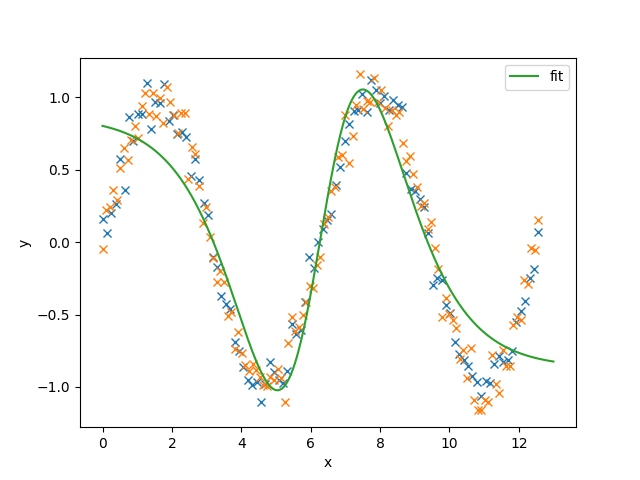

In [24]:
# plot the data and the fit
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

## 2c Width

In [25]:
# Experiment with different hidden layer sizes. To avoid recomputing
# models, you may want to save your models using torch.save(model, filename) and
# load them again using torch.load(filename).

for i in [1, 2, 3, 10, 50, 100]:
    model = train1([i], nreps = 1)
    print("Training error:", F.mse_loss(y1, model(X1)).item())
    print("Test error    :", F.mse_loss(y1test, model(X1test)).item())
    torch.save(model, f"model_{i}.pth")

X1 shape: torch.Size([100, 1])
Repetition  0: Optimization terminated successfully.
         Current function value: 0.372919
         Iterations: 42
         Function evaluations: 47
         Gradient evaluations: 47
best_cost=0.373
Training error: 0.3729189336299896
Test error    : 0.3743167221546173
X1 shape: torch.Size([100, 1])
Repetition  0: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 390
         Function evaluations: 593
         Gradient evaluations: 583
best_cost=0.080
Training error: 0.07957376539707184
Test error    : 0.08670931309461594
X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.049892
         Iterations: 289
         Function evaluations: 469
         Gradient evaluations: 456
best_cost=0.050
Training error: 0.04989229515194893
Test error    : 0.0598050132393837
X1 shape: torch.Size([100, 1])
Repetition  0: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.005721
         Iterations: 1026
         Function evaluations: 1250
         Gradient evaluations: 1234
best_cost=0.006
Training error: 0.0057213036343455315
Test error    : 0.0150537034496665
X1 shape: torch.Size([100, 1])
Repetition  0: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003007
         Iterations: 5655
         Function evaluations: 6282
         Gradient evaluations: 6268
best_cost=0.003
Training error: 0.0030068017076700926
Test error    : 2.0873610973358154
X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.001826
         Iterations: 8126
         Function evaluations: 8804
         Gradient evaluations: 8792
best_cost=0.002
Training error: 0.001825749408453703
Test error    : 4.303783893585205


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


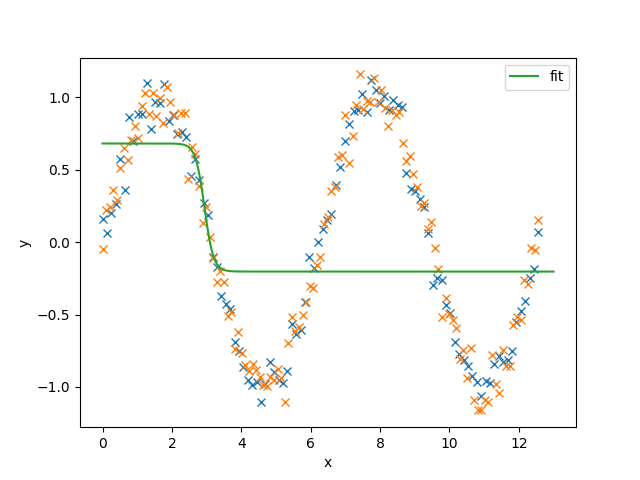

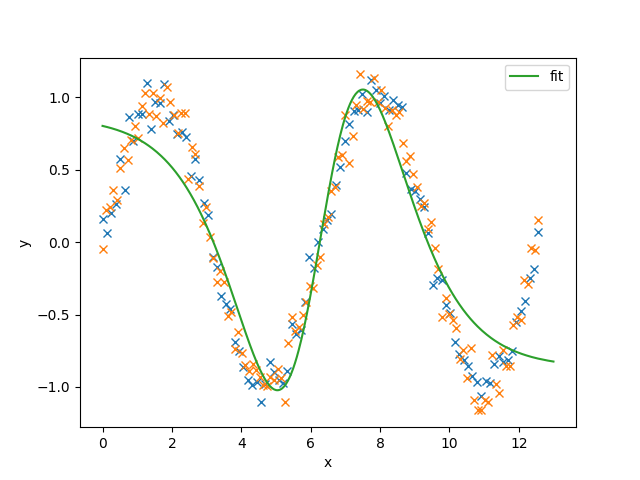

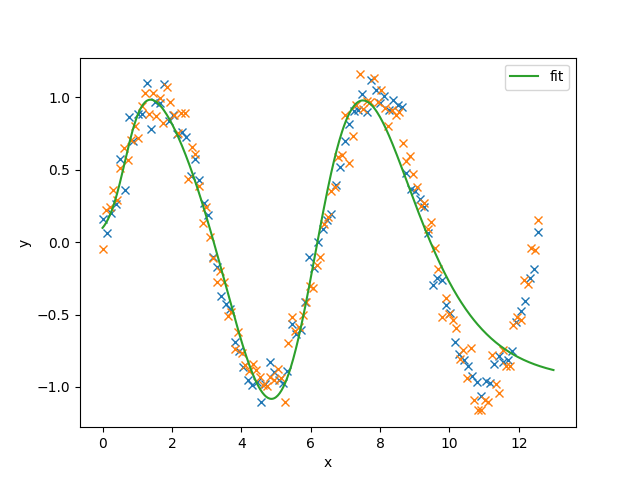

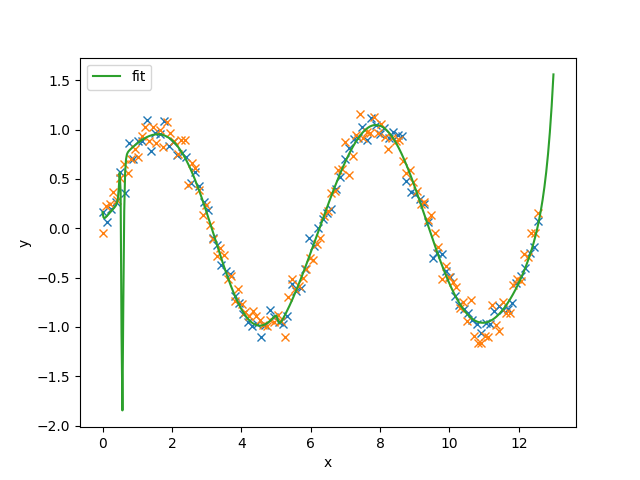

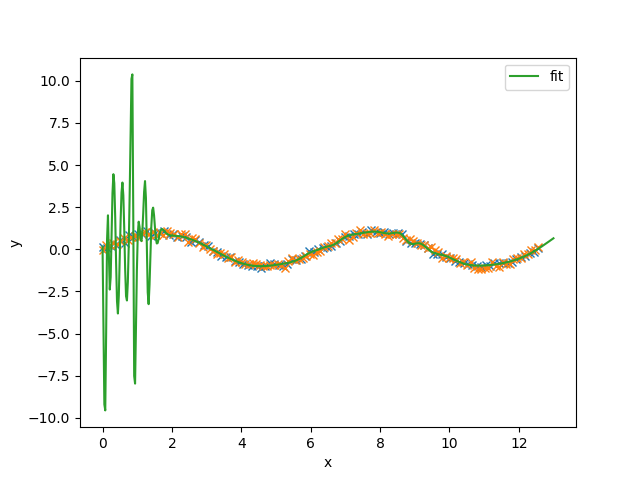

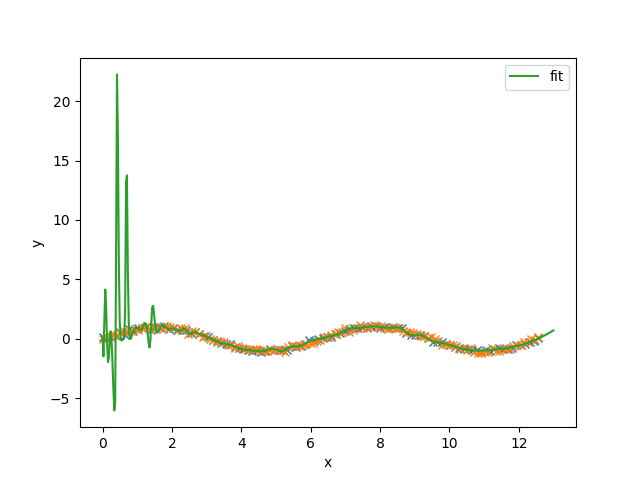

In [26]:
# torch.load(filename)

for i in [1, 2, 3, 10, 50, 100]:
    model = torch.load(f"model_{i}.pth")
    nextplot()
    plot1(X1, y1, label="train")
    plot1(X1test, y1test, label="test")
    plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

## 2d Distributed representations

In [27]:
# train a model to analyze
model = train1([2])

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.079573
         Iterations: 399
         Function evaluations: 542
         Gradient evaluations: 533
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  1: Optimization terminated successfully.
         Current function value: 0.301865
         Iterations: 131
         Function evaluations: 161
         Gradient evaluations: 161
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  2: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 384
         Function evaluations: 538
         Gradient evaluations: 526
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  3:          Current function value: 0.079573
         Iterations: 379
         Function evaluations: 534
         Gradient evaluations: 523
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  4: Optimization terminated successfully.
         Current function value: 0.372457
         Iterations: 131
         Function evaluations: 137
         Gradient evaluations: 137
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  5: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 402
         Function evaluations: 536
         Gradient evaluations: 525
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  6: Optimization terminated successfully.
         Current function value: 0.277769
         Iterations: 86
         Function evaluations: 97
         Gradient evaluations: 97
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  7: Optimization terminated successfully.
         Current function value: 0.357250
         Iterations: 85
         Function evaluations: 90
         Gradient evaluations: 90
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.079572
         Iterations: 392
         Function evaluations: 619
         Gradient evaluations: 605
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.079573
         Iterations: 403
         Function evaluations: 646
         Gradient evaluations: 6

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


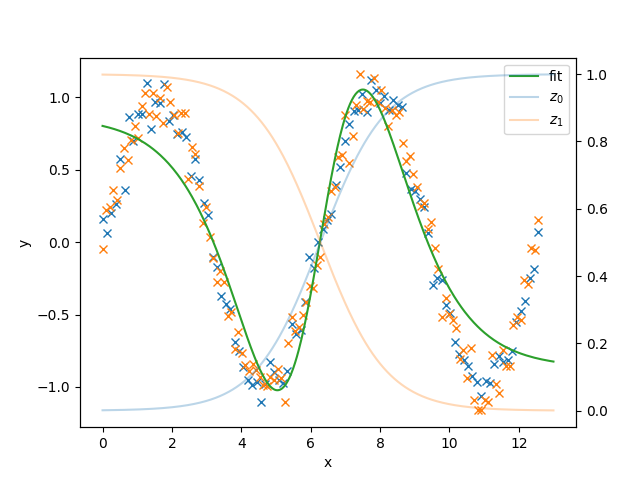

In [28]:
# plot the fit as well as the outputs of each neuron in the hidden
# layer (scale for the latter is shown on right y-axis)
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model, hidden=True, scale=False)

In [29]:
# train a model to analyze
model = train1([3])

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.007324
         Iterations: 422
         Function evaluations: 535
         Gradient evaluations: 523
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  1: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079572
         Iterations: 397
         Function evaluations: 577
         Gradient evaluations: 565
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  2:          Current function value: 0.007324
         Iterations: 543
         Function evaluations: 689
         Gradient evaluations: 677
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  3: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.049886
         Iterations: 317
         Function evaluations: 514
         Gradient evaluations: 503
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  4: Optimization terminated successfully.
         Current function value: 0.042560
         Iterations: 155
         Function evaluations: 172
         Gradient evaluations: 172
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  5:          Current function value: 0.079573
         Iterations: 364
         Function evaluations: 561
         Gradient evaluations: 548
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  6: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 343
         Function evaluations: 561
         Gradient evaluations: 548
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  7:          Current function value: 0.049901
         Iterations: 221
         Function evaluations: 320
         Gradient evaluations: 308
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  8: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.049877
         Iterations: 563
         Function evaluations: 811
         Gradient evaluations: 799
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.053823
         Iterations: 540
         Function evaluations: 743
         Gradient evaluations: 728
best_cost=0.007


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


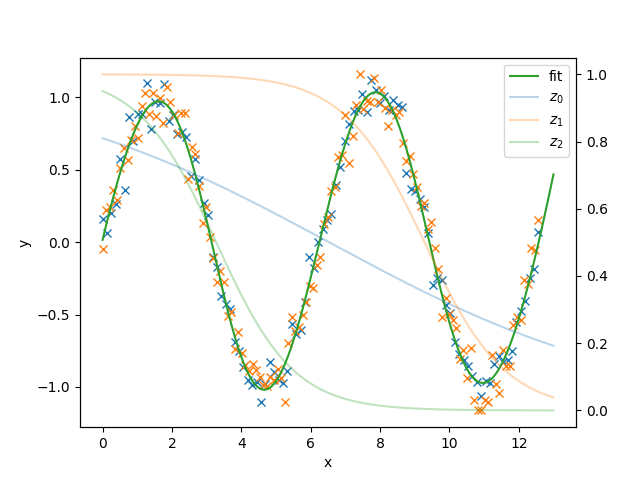

In [30]:
# plot the fit as well as the outputs of each neuron in the hidden
# layer (scale for the latter is shown on right y-axis)
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model, hidden=True, scale=False)

In [31]:
# train a model to analyze
model = train1([10])

X1 shape: torch.Size([100, 1])
Repetition  0: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006069
         Iterations: 2361
         Function evaluations: 2702
         Gradient evaluations: 2683
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  1: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006260
         Iterations: 2624
         Function evaluations: 3005
         Gradient evaluations: 2995
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  2:          Current function value: 0.006688
         Iterations: 587
         Function evaluations: 696
         Gradient evaluations: 686
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  3: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006667
         Iterations: 1257
         Function evaluations: 1487
         Gradient evaluations: 1475
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  4: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006232
         Iterations: 1648
         Function evaluations: 1908
         Gradient evaluations: 1897
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  5: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006114
         Iterations: 1489
         Function evaluations: 1719
         Gradient evaluations: 1707
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  6: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006576
         Iterations: 2629
         Function evaluations: 2955
         Gradient evaluations: 2945
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  7: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006076
         Iterations: 1852
         Function evaluations: 2128
         Gradient evaluations: 2116
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  8: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006614
         Iterations: 2289
         Function evaluations: 2825
         Gradient evaluations: 2807
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.006805
         Iterations: 1034
         Function evaluations: 1288
         Gradient evaluations: 1275
best_cost=0.006


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


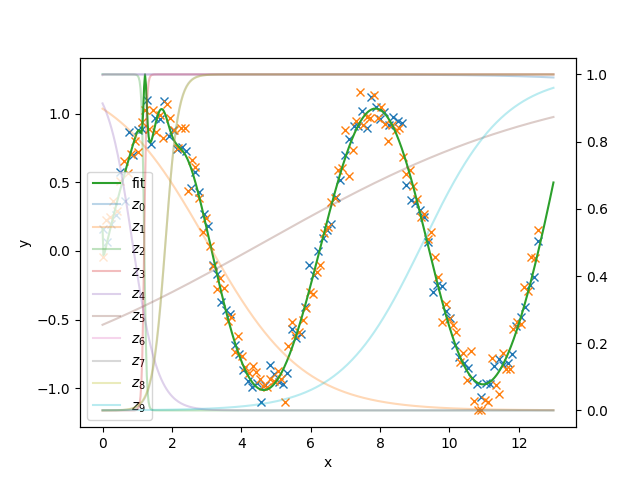

In [32]:
# plot the fit as well as the outputs of each neuron in the hidden
# layer (scale for the latter is shown on right y-axis)
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model, hidden=True, scale=False)

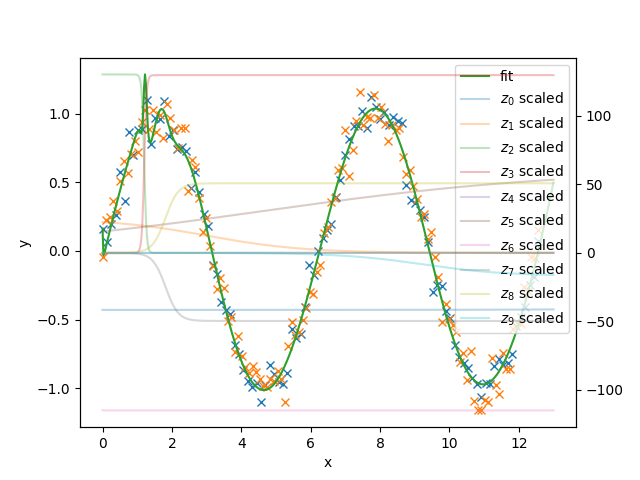

In [33]:
# plot the fit as well as the outputs of each neuron in the hidden layer, scaled
# by its weight for the output neuron (scale for the latter is shown on right
# y-axis)

nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model, hidden=True, scale=True)

## 2e Experiment with different optimizers (optional)

In [34]:
# PyTorch provides many gradient-based optimizers; see
# https://pytorch.org/docs/stable/optim.html. You can use a PyTorch optimizer
# as follows.
train_adam = lambda model, **kwargs: fnn_train(
    X1, y1, model, optimizer=torch.optim.Adam(model.parameters(), lr=0.01), **kwargs
)
model = train1([50], nreps=1, train=train_adam, max_epochs=5000, tol=1e-8, verbose=True)

X1 shape: torch.Size([100, 1])
Repetition  0: Epoch     0: cost=   0.561 
Epoch     1: cost=   0.547 
Epoch     2: cost=   0.508 
Epoch     3: cost=   0.491 
Epoch     4: cost=   0.482 
Epoch     5: cost=   0.464 
Epoch     6: cost=   0.450 
Epoch     7: cost=   0.447 
Epoch     8: cost=   0.445 
Epoch     9: cost=   0.439 
Epoch    10: cost=   0.437 
Epoch    11: cost=   0.440 
Epoch    12: cost=   0.443 
Epoch    13: cost=   0.443 
Epoch    14: cost=   0.443 
Epoch    15: cost=   0.445 
Epoch    16: cost=   0.446 
Epoch    17: cost=   0.445 
Epoch    18: cost=   0.443 
Epoch    19: cost=   0.441 
Epoch    20: cost=   0.441 
Epoch    21: cost=   0.438 
Epoch    22: cost=   0.436 
Epoch    23: cost=   0.434 
Epoch    24: cost=   0.433 
Epoch    25: cost=   0.431 
Epoch    26: cost=   0.430 
Epoch    27: cost=   0.429 
Epoch    28: cost=   0.428 
Epoch    29: cost=   0.428 
Epoch    30: cost=   0.428 
Epoch    31: cost=   0.427 
Epoch    32: cost=   0.427 
Epoch    33: cost=   0.427 
Ep

X1 shape: torch.Size([100, 1])
Repetition  0: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.027642
         Iterations: 106
         Function evaluations: 226
         Gradient evaluations: 221
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  1:          Current function value: 0.372736
         Iterations: 20
         Function evaluations: 93
         Gradient evaluations: 89
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  2:          Current function value: 0.082316
         Iterations: 77
         Function evaluations: 175
         Gradient evaluations: 169
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  3: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.372829
         Iterations: 54
         Function evaluations: 224
         Gradient evaluations: 219
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.356289
         Iterations: 62
         Function evaluations: 159
         Gradient evaluations: 151
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  5: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.436769
         Iterations: 19
         Function evaluations: 107
         Gradient evaluations: 98
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  6:          Current function value: 0.082545
         Iterations: 87
         Function evaluations: 201
         Gradient evaluations: 196
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  7: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355800
         Iterations: 47
         Function evaluations: 226
         Gradient evaluations: 220
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  8: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.098439
         Iterations: 131
         Function evaluations: 239
         Gradient evaluations: 227
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.355687
         Iterations: 139
         Function evaluations: 261
         Gradient evaluations: 257
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  10: Optimization terminated successfully.
         Current function value: 0.101445
         Iterations: 53
         Function evaluations: 66
         Gradient evaluations: 66
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  11: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.356116
         Iterations: 52
         Function evaluations: 161
         Gradient evaluations: 155
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  12:          Current function value: 0.435001
         Iterations: 46
         Function evaluations: 123
         Gradient evaluations: 119
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  13: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.435068
         Iterations: 41
         Function evaluations: 131
         Gradient evaluations: 125
best_cost=0.028
X1 shape: torch.Size([100, 1])
Repetition  14: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.007341
         Iterations: 212
         Function evaluations: 447
         Gradient evaluations: 433
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  15:          Current function value: 0.355830
         Iterations: 46
         Function evaluations: 140
         Gradient evaluations: 135
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  16: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.353423
         Iterations: 154
         Function evaluations: 435
         Gradient evaluations: 415
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  17:          Current function value: 0.405736
         Iterations: 15
         Function evaluations: 95
         Gradient evaluations: 90
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  18:          Current function value: 0.085500
         Iterations: 113
         Function evaluations: 241
         Gradient evaluations: 234
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  19: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.082287
         Iterations: 96
         Function evaluations: 187
         Gradient evaluations: 183
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  20:          Current function value: 0.434775
         Iterations: 18
         Function evaluations: 113
         Gradient evaluations: 102
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  21: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.356477
         Iterations: 34
         Function evaluations: 122
         Gradient evaluations: 118
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  22:          Current function value: 0.355919
         Iterations: 54
         Function evaluations: 154
         Gradient evaluations: 149
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  23: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.008464
         Iterations: 251
         Function evaluations: 460
         Gradient evaluations: 451
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  24: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.008703
         Iterations: 185
         Function evaluations: 276
         Gradient evaluations: 270
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  25: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355581
         Iterations: 138
         Function evaluations: 261
         Gradient evaluations: 255
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  26:          Current function value: 0.085421
         Iterations: 55
         Function evaluations: 161
         Gradient evaluations: 155
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  27:          Current function value: 0.357612
         Iterations: 46
         Function evaluations: 123
         Gradient evaluations: 116
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  28: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.434378
         Iterations: 34
         Function evaluations: 122
         Gradient evaluations: 116
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  29: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.083644
         Iterations: 205
         Function evaluations: 328
         Gradient evaluations: 323
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  30: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.434433
         Iterations: 28
         Function evaluations: 111
         Gradient evaluations: 107
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  31:          Current function value: 0.356297
         Iterations: 72
         Function evaluations: 166
         Gradient evaluations: 161
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  32: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.005862
         Iterations: 382
         Function evaluations: 528
         Gradient evaluations: 523
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  33:          Current function value: 0.308671
         Iterations: 68
         Function evaluations: 180
         Gradient evaluations: 175
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  34: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.436922
         Iterations: 60
         Function evaluations: 163
         Gradient evaluations: 155
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  35:          Current function value: 0.435347
         Iterations: 37
         Function evaluations: 109
         Gradient evaluations: 101
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  36: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.371726
         Iterations: 35
         Function evaluations: 118
         Gradient evaluations: 113
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  37:          Current function value: 0.008174
         Iterations: 108
         Function evaluations: 221
         Gradient evaluations: 217
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  38: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355790
         Iterations: 129
         Function evaluations: 232
         Gradient evaluations: 227
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  39: Optimization terminated successfully.
         Current function value: 0.435275
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 52
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  40:          Current function value: 0.435287
         Iterations: 18
         Function evaluations: 99
         Gradient evaluations: 94
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  41: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.372387
         Iterations: 57
         Function evaluations: 177
         Gradient evaluations: 173
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  42:          Current function value: 0.356134
         Iterations: 110
         Function evaluations: 214
         Gradient evaluations: 209
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  43: Optimization terminated successfully.
         Current function value: 0.098100
         Iterations: 147
         Function evaluations: 169
         Gradient evaluations: 169
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  44:          Current function value: 0.356624
         Iterations: 28
         Function evaluations: 115
         Gradient evaluations: 103
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  45: Optimization terminated successfully.
         Current function value: 0.506238
         Iterations: 14
         Function evaluations: 16
         Gradient evaluati

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.092225
         Iterations: 89
         Function evaluations: 209
         Gradient evaluations: 204
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  47: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355652
         Iterations: 168
         Function evaluations: 310
         Gradient evaluations: 306
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  48: 

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.008766
         Iterations: 145
         Function evaluations: 251
         Gradient evaluations: 243
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  49:          Current function value: 0.007130
         Iterations: 196
         Function evaluations: 295
         Gradient evaluations: 288
best_cost=0.006
Training error: 0.005861788988113403
Test error    : 0.010837704874575138


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


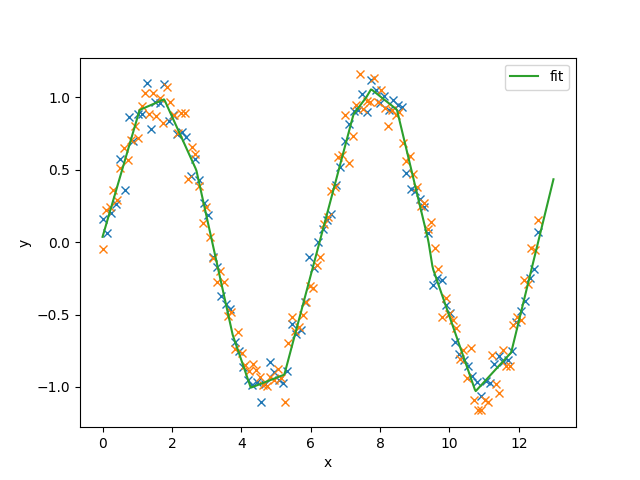

In [35]:
# Experiment with different number of layers and activation functions. Here is
# an example with three hidden layers (of sizes 4, 5, and 6) and ReLU activations.
#
# You can also plot the outputs of the hidden neurons in the first layer (using
# the same code above).
model = train1([4, 5, 6], nreps=50, phi=F.relu)
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)
print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

# 3 Backpropagation

In [36]:
# Let's fit the model with one hidden layer consisting of 50 units.
model = train1([50], nreps=1)
print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

# Extract parameters
pars = dict(model.named_parameters())
W1 = pars["0_weight"].data  # 1x50
b1 = pars["0_bias"].data  # 50
W2 = pars["1_weight"].data  # 50x1
b2 = pars["1_bias"].data  # 1

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.004436
         Iterations: 3943
         Function evaluations: 4298
         Gradient evaluations: 4289
best_cost=0.004
Training error: 0.004435778129845858
Test error    : 26.959814071655273


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


## 3a Forward pass

In [37]:
# Compute results of forward pass on an example x (i.e., z1, z2, z3, z4, yhat, l) using Pytorch
x = X1test[1, :]
y = y1test[1, :]
print(f"x={x}, y={y}, yhat={model(x).detach()}, l={torch.nn.MSELoss()(y,model(x))}")

x=tensor([0.1030]), y=tensor([0.2253]), yhat=tensor([[-1.3225]]), l=2.3957338333129883


/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [38]:
# Now do this by hand (including all intermediate values). You should get the same
# results as above.
z1 = W1.t() * x
z2 = z1 + b1.unsqueeze(1)
z3 = 1/ (1 + torch.exp(-1 * z2))
z4 = torch.zeros(1, 1)
for i in range(W2.shape[0]):
    z4 += W2[i] * z3[i]
y_hat = z4 + b2
l = (y - y_hat)**2
print(f"x={x}, y={y}, yhat={y_hat}, l={l}")

x=tensor([0.1030]), y=tensor([0.2253]), yhat=tensor([[-1.3226]]), l=tensor([[2.3958]])


## 3b Backward pass

In [39]:
# Compute results of backward pass on example output (i.e., delta_x, delta_W1, delta_z1,
# delta_b1, delta_z2, delta_z3, delta_W2, delta_z4, delta_b2, delta_yhat, delta_l, delta_y)

delta_l = 1
delta_y = (2 * (y - y_hat)).squeeze(1)
delta_yhat = -2 * (y - y_hat)
delta_b2 = (delta_yhat * 1).squeeze(1)
delta_z4 = delta_yhat * 1
delta_W2 = delta_z4 * z3
delta_z3 = delta_z4 * W2
delta_z2 = delta_z3 * z3 * (1 - z3)
delta_b1 = delta_z2.squeeze(1)
delta_z1 = delta_z2

delta_x = torch.zeros(1, 1)
for i in range(W1.shape[0]):
    delta_x += delta_z1[i] * W1[0][i]
delta_x = delta_x.squeeze(1)

delta_W1 = (delta_z1 * x).t()

In [40]:
# Use PyTorch's backprop
x.requires_grad = True
y.requires_grad = True
if x.grad is not None:
    x.grad.zero_()
if y.grad is not None:
    y.grad.zero_()
model.zero_grad()
t_yhat = model(x)
t_yhat.retain_grad()
t_l = torch.nn.MSELoss()(t_yhat, y)
t_l.backward()
t_delta_l = 1
t_delta_y = y.grad
t_delta_yhat = t_yhat.grad
t_delta_b2 = model.get_parameter("1_bias").grad
t_delta_W2 = model.get_parameter("1_weight").grad
t_delta_b1 = model.get_parameter("0_bias").grad
t_delta_W1 = model.get_parameter("0_weight").grad
t_delta_x = x.grad

/Users/ngkokteng/PycharmProjects/Deep Learning/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [41]:
# Check if equal (show squared error)
for v in ["y", "yhat", "b2", "W2", "b1", "W1", "x"]:
    print(f'{v}, squared error={torch.sum((eval("t_delta_"+v)-eval("delta_"+v))**2)}')

y, squared error=2.3283064365386963e-10
yhat, squared error=2.3283064365386963e-10
b2, squared error=2.3283064365386963e-10
W2, squared error=5.1774509124413726e-09
b1, squared error=1.7092266091367492e-07
W1, squared error=1.8068877505328373e-09
x, squared error=1213.602294921875


In [42]:
# Check if equal (show actual values)
for v in ["l", "y", "yhat", "b2", "W2", "b1", "W1", "x"]:
    print(f'{v}, pytorch={eval("t_delta_"+v)}, you={eval("delta_"+v)}')

l, pytorch=1, you=1
y, pytorch=tensor([3.0956]), you=tensor([3.0956])
yhat, pytorch=tensor([[-3.0956]]), you=tensor([[-3.0956]])
b2, pytorch=tensor([-3.0956]), you=tensor([-3.0956])
W2, pytorch=tensor([[-3.0885e+00],
        [-2.7294e+00],
        [-3.0956e+00],
        [-3.0860e+00],
        [-1.9720e-05],
        [-2.1162e-01],
        [-1.5810e-05],
        [-1.9257e-26],
        [-3.0956e+00],
        [-2.8082e+00],
        [-6.7645e-03],
        [-2.8477e+00],
        [-6.4975e-18],
        [-1.4684e+00],
        [-2.8181e-05],
        [-1.2377e-06],
        [-3.0956e+00],
        [-1.3328e-31],
        [-6.4777e-07],
        [-3.0956e+00],
        [-1.2281e+00],
        [-2.8658e+00],
        [-1.9031e-02],
        [-3.0956e+00],
        [-4.3156e-05],
        [-2.6180e-01],
        [-5.3807e-03],
        [-2.3027e+00],
        [-1.3252e-06],
        [-3.1496e-01],
        [-3.0956e+00],
        [-1.3970e+00],
        [-2.8697e+00],
        [-3.0956e+00],
        [-4.4417e-01],
 